In [1]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, v_measure_score, fowlkes_mallows_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import hashlib

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)

def map_to_hash(text):
    encoded_string = text.encode('utf-8') 
    sha256_hash = hashlib.sha256(encoded_string)
    hex_digest = sha256_hash.hexdigest()
    return hex_digest

In [2]:
from str_bamba.load import load_bamba
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load model
model = load_bamba(
    base_folder='./str_bamba',
    config_filename='config_encoder-decoder_436M.json',
    ckpt_filename='STR-Bamba_8.pt', 
    tokenizer_filename='tokenizer_v3.json',
    device='cuda',
    dtype=torch.float32
)
model.eval()

/dccstor/kcsys/vys/miniforge3/envs/bamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-08-04 09:32:58,760] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/dccstor/kcsys/vys/miniforge3/envs/bamba/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/dccstor/kcsys/vys/miniforge3/envs/bamba/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


Random Seed: 0


BambaEncoderDecoder(
  (encoder): BambaEncoder(
    (backbone): BambaMixerModel(
      (embedding): BertEmbeddings(
        (word_embeddings): Embedding(5000, 1024, padding_idx=2)
        (token_type_embeddings): Embedding(2, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layers): ModuleList(
        (0-5): 6 x Block(
          (norm): RMSNorm()
          (mixer): Mamba2(
            (in_proj): Linear(in_features=1024, out_features=4384, bias=False)
            (conv1d): Conv1d(2304, 2304, kernel_size=(4,), stride=(1,), padding=(3,), groups=2304)
            (act): SiLU()
            (norm): RMSNorm()
            (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
          )
        )
        (6): Block(
          (norm): RMSNorm()
          (mixer): MHA(
            (rotary_emb): RotaryEmbedding()
            (in_proj): Linear(in_features=1024, out_features=2048, bias=Fa

In [3]:
df_pubchem = pd.read_csv('../data/datasets/normprops_100k_sample.csv')
df_polymer = pd.read_csv('../data/datasets/polymer_100k_sample.csv')
# df_formulation = pd.read_csv('../data/datasets/formulation/ionic/train.csv')
df_formulation = pd.read_csv('../data/datasets/formulation_data.csv')

df_polymer['index'] = df_polymer['POLYMER SMILES'].apply(map_to_hash)
df_formulation['index'] = df_formulation['FORMULATION'].apply(map_to_hash)

In [4]:
df_pubchem_sample = pd.melt(df_pubchem.sample(2000, random_state=SEED), id_vars=['CID'], value_vars=[
    'MOLECULAR_FORMULA', 
    'CANONICAL_SMILES', 
    'IUPAC_NAME', 
    'INCHI', 
    'SELFIES',
])
df_pubchem_sample

,CID,variable,value
0,134161487,MOLECULAR_FORMULA,<formula>C14H12N4
1,140161468,MOLECULAR_FORMULA,<formula>C21H18ClLiN4O4S2
2,43963595,MOLECULAR_FORMULA,<formula>C25H31FN4O3S2
3,135311515,MOLECULAR_FORMULA,<formula>C19H21N9O4S3
4,163423022,MOLECULAR_FORMULA,<formula>C25H30N5O2+
...,...,...,...
9995,109326077,SELFIES,<selfies>[C][C][N][C][C][N][Branch2][Ring1][P]...
9996,86680815,SELFIES,<selfies>[C][O][C][=C][C][=C][Branch2][Ring2][...
9997,11922629,SELFIES,<selfies>[O][=C][Branch1][C][O-1][C][C][C][=C]...
9998,168019075,SELFIES,<selfies>[C][C][=C][C][=C][Branch1][#C][C][N][...


In [5]:
df_polymer_sample = pd.melt(df_polymer.sample(2000, random_state=SEED), id_vars=['index'], value_vars=[
    'POLYMER SMILES',
])
df_polymer_sample

,index,variable,value
0,8e9a27e13cb994abdd3f4501ae236c3cf9336aac8e5d79...,POLYMER SMILES,<polymer_spg>[*:1]C1CC(C)(C)CC(C)(CNC(=O)OCCOC...
1,09c631a5b76ebc05635b5b125877088717e51d6c67c42c...,POLYMER SMILES,<polymer_spg>[*:1]CCCCCCC([H])C([*:2])(C)CC;2->1
2,4919cadeef654a4bd414ec6f0a30cab8e59d9ccaf70868...,POLYMER SMILES,<polymer_spg>[*:1]C=Cc1cc(OCCCN(C)c2cccc(C)c2[...
3,51f9aa954f1a59418fd47213ce296979747a77338818ec...,POLYMER SMILES,<polymer_spg>[*:1]NC(Cc1cccnc1N1C(=O)C2CC(C1=O...
4,64cd9d7a828a914668cf824e92a1e839691886537eb212...,POLYMER SMILES,<polymer_spg>[*:1]c1nc(NN2C(=O)c3ccc4c5c(Br)cc...
...,...,...,...
1995,39899d6839d2e49080962e998e10d12d251f700bc4d1f2...,POLYMER SMILES,<polymer_spg>[*:1]c1cc(C(F)(F)F)cc(C(C)(C)c2cc...
1996,0ccfb41dd0b2361a4e30bcacda8000ed68d37a7b06ccdd...,POLYMER SMILES,<polymer_spg>[*:1]NC(c1cc(C)cnc1N1C(=O)C2=C(C1...
1997,bed1ed1b69e778b478a830729366568e9e94dc41ccd904...,POLYMER SMILES,<polymer_spg>[*:1]CCOCOC(=O)OCCCCCCOC(=O)C(=O)...
1998,4bc07f3bed76db553c29dbc560012e40a17f7f53fc653e...,POLYMER SMILES,<polymer_spg>[*:1]C(CCCC)CSSCC(CCCC)N1C(=O)c2c...


In [6]:
df_formulation_sample = pd.melt(df_formulation, id_vars=['index'], value_vars=[
    'FORMULATION',
])
df_formulation_sample

,index,variable,value
0,b5e55f1370aeb2931f886671ef055474ff515d9938213f...,FORMULATION,<formulation_start>COCCC#N<sep>56.0<sep>COCCC#...
1,866936ed356d47ec73f8bef1a5495899fa96a517c5e8e9...,FORMULATION,<formulation_start>COCCC#N<sep>56.0<sep>COCCOC...
2,502e1065a910c9e6fdd43550c83c109024945ba2f0489a...,FORMULATION,<formulation_start>COCCC#N<sep>56.0<sep>C1=CC=...
3,79ac320789ae3131933aa205aa848a52115c9c39d648a5...,FORMULATION,<formulation_start>COCCC#N<sep>52.0<sep>COCCOC...
4,ab71c3553e7d9f42450dac2a9bd9bceb34761d7ea4b91f...,FORMULATION,<formulation_start>COCCC#N<sep>56.0<sep>CC=CC#...
...,...,...,...
253,b3be2aec9f6cad691b48f4e24f344f43d5e76a541645cb...,FORMULATION,<formulation_start>C1COC(=O)O1<sep>33.78<sep>C...
254,5db6c2dc8228851000842043fa29d847f08672da729be4...,FORMULATION,<formulation_start>COCCOC<sep>73.12<sep>[Li+]....
255,f880d2f15712a6060504d219c9f7454aa64f9ff6999aec...,FORMULATION,<formulation_start>COCCOCCOCCOCCOC<sep>81.95<s...
256,365d87f8577f9a4299ad856dc70cb5d2ab163a92371a9a...,FORMULATION,<formulation_start>C1C(OC(=O)O1)F<sep>49.68<se...


In [7]:
df_polymer_sample = df_polymer_sample.rename(columns={'index': 'CID'})
df_formulation_sample = df_formulation_sample.rename(columns={'index': 'CID'})

df_sample = pd.concat([df_pubchem_sample, df_polymer_sample, df_formulation_sample]).reset_index(drop=True)
df_sample

,CID,variable,value
0,134161487,MOLECULAR_FORMULA,<formula>C14H12N4
1,140161468,MOLECULAR_FORMULA,<formula>C21H18ClLiN4O4S2
2,43963595,MOLECULAR_FORMULA,<formula>C25H31FN4O3S2
3,135311515,MOLECULAR_FORMULA,<formula>C19H21N9O4S3
4,163423022,MOLECULAR_FORMULA,<formula>C25H30N5O2+
...,...,...,...
12253,b3be2aec9f6cad691b48f4e24f344f43d5e76a541645cb...,FORMULATION,<formulation_start>C1COC(=O)O1<sep>33.78<sep>C...
12254,5db6c2dc8228851000842043fa29d847f08672da729be4...,FORMULATION,<formulation_start>COCCOC<sep>73.12<sep>[Li+]....
12255,f880d2f15712a6060504d219c9f7454aa64f9ff6999aec...,FORMULATION,<formulation_start>COCCOCCOCCOCCOC<sep>81.95<s...
12256,365d87f8577f9a4299ad856dc70cb5d2ab163a92371a9a...,FORMULATION,<formulation_start>C1C(OC(=O)O1)F<sep>49.68<se...


In [8]:
with torch.no_grad():
    embeddings = model.encode(df_sample['value'].to_list(), return_torch=True)
    print(embeddings.shape)

embeddings = pd.DataFrame(embeddings.numpy())

/dccstor/kcsys/vys/miniforge3/envs/bamba/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
100%|███████████████████████████████████████████████████████████████████████████| 766/766 [00:53<00:00, 14.23it/s]


torch.Size([12258, 1024])


/dccstor/kcsys/vys/bamba_eval/latent_space/str_bamba/bamba.py:553: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(flat_list)


In [9]:
%%time
X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30, n_jobs=1, random_state=SEED).fit_transform(embeddings)
X_embedded.shape

CPU times: user 4h 3min 39s, sys: 1min 18s, total: 4h 4min 58s
Wall time: 1min 18s


(12258, 2)

In [10]:
df_plot = pd.concat([pd.DataFrame(X_embedded), df_sample.reset_index(drop=True)], axis=1)
df_plot['CID'] = df_plot['CID'].apply(str)
df_plot.head()

,0,1,CID,variable,value
0,63.045738,33.497715,134161487,MOLECULAR_FORMULA,<formula>C14H12N4
1,74.415123,-6.772320,140161468,MOLECULAR_FORMULA,<formula>C21H18ClLiN4O4S2
2,62.771534,-10.461547,43963595,MOLECULAR_FORMULA,<formula>C25H31FN4O3S2
3,78.384171,5.493863,135311515,MOLECULAR_FORMULA,<formula>C19H21N9O4S3
4,76.692535,-2.183498,163423022,MOLECULAR_FORMULA,<formula>C25H30N5O2+


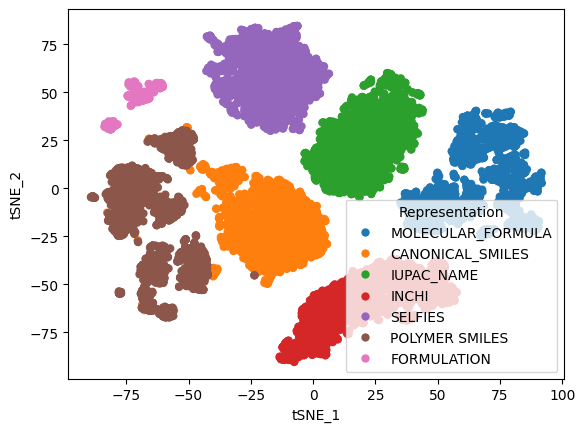

In [21]:
ax = sns.scatterplot(df_plot.rename(columns={'variable': 'Representation'}), x=0, y=1, hue='Representation', linewidth=0, legend=True)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.title('STR-Bamba: latent space projection by representation type')
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.savefig('str-bamba_latent_space_legend.png', bbox_inches='tight')
plt.show()

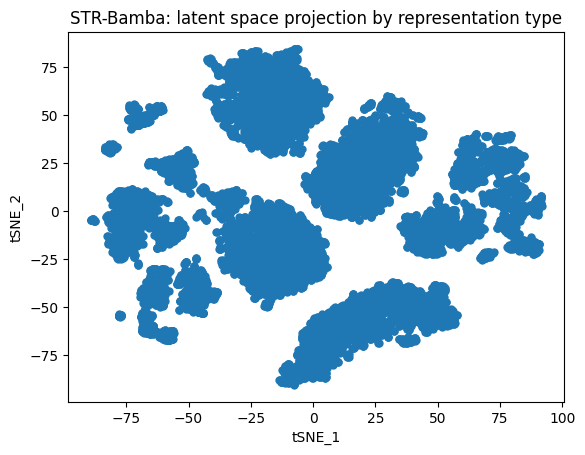

In [13]:
ax = sns.scatterplot(df_plot, x=0, y=1, linewidth=0)
plt.title('STR-Bamba: latent space projection by representation type')
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.savefig('str-smi-ted_latent_space.png', bbox_inches='tight')
plt.show()

In [22]:
true_labels, mapping = pd.factorize(df_plot['variable'])

for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=SEED, n_init=10)
    labels = kmeans.fit_predict(X_embedded)

    db_score = davies_bouldin_score(X_embedded, labels)
    ari = adjusted_rand_score(true_labels, labels)
    nmi = normalized_mutual_info_score(true_labels, labels)
    v_measure = v_measure_score(true_labels, labels)
    fm = fowlkes_mallows_score(true_labels, labels)

    print('')
    print('n_clusters:', n)
    print('Davies-Bouldin:', round(db_score, 2))
    print('ARI:', round(ari, 2))
    print('NMI:', round(nmi, 2))
    print('V-Measure:', round(v_measure, 2))
    print('Fowlkes-Mallows:', round(fm, 2))


n_clusters: 2
Davies-Bouldin: 1.18
ARI: 0.26
NMI: 0.43
V-Measure: 0.43
Fowlkes-Mallows: 0.51

n_clusters: 3
Davies-Bouldin: 0.87
ARI: 0.41
NMI: 0.57
V-Measure: 0.57
Fowlkes-Mallows: 0.58

n_clusters: 4
Davies-Bouldin: 0.73
ARI: 0.61
NMI: 0.74
V-Measure: 0.74
Fowlkes-Mallows: 0.71

n_clusters: 5
Davies-Bouldin: 0.75
ARI: 0.74
NMI: 0.82
V-Measure: 0.82
Fowlkes-Mallows: 0.8

n_clusters: 6
Davies-Bouldin: 0.81
ARI: 0.84
NMI: 0.88
V-Measure: 0.88
Fowlkes-Mallows: 0.86

n_clusters: 7
Davies-Bouldin: 0.7
ARI: 0.91
NMI: 0.92
V-Measure: 0.92
Fowlkes-Mallows: 0.92

n_clusters: 8
Davies-Bouldin: 0.69
ARI: 0.84
NMI: 0.88
V-Measure: 0.88
Fowlkes-Mallows: 0.87

n_clusters: 9
Davies-Bouldin: 0.71
ARI: 0.79
NMI: 0.87
V-Measure: 0.87
Fowlkes-Mallows: 0.83

n_clusters: 10
Davies-Bouldin: 0.71
ARI: 0.79
NMI: 0.87
V-Measure: 0.87
Fowlkes-Mallows: 0.83


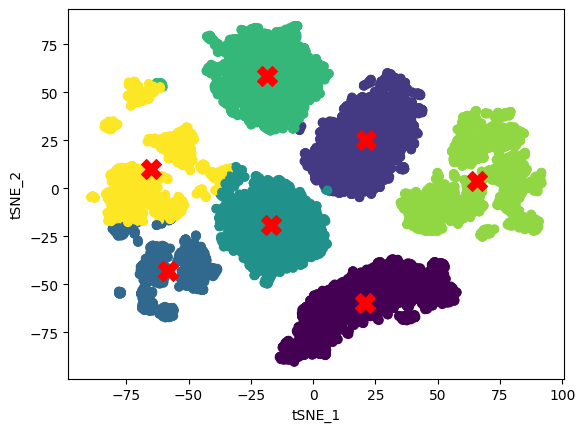

In [18]:
kmeans = KMeans(n_clusters=7, random_state=SEED, n_init='auto')
kmeans.fit(X_embedded)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Get the coordinates of the cluster centroids
centroids = kmeans.cluster_centers_

# Visualize the clusters and centroids
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red')
# plt.title('K-means Clustering')
plt.xlabel('tSNE_1')
plt.ylabel('tSNE_2')
plt.savefig('str-bamba_kmeans.png', bbox_inches='tight')
plt.show()